In [6]:
from dataclasses import asdict

import numpy as np
import pandas as pd

from src.evaluator import DatasetBuilder
from src.graph import subgraph, gen_graph, periodic_of, non_periodic_node
from src.args import Args
import seaborn as sns
import networkx as nx
import matplotlib.pyplot as plt
from datetime import datetime

In [2]:
import os

if os.getcwd().endswith("notebooks"):
    os.chdir("..")
    print("using project root as working dir")

using project root as working dir


In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
# global seaborn settings
sns.set_context("paper")
sns.set_style("darkgrid", { "grid.color": ".8" })

palette = "Dark2"

# Generate Graph

Generates the graph and

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


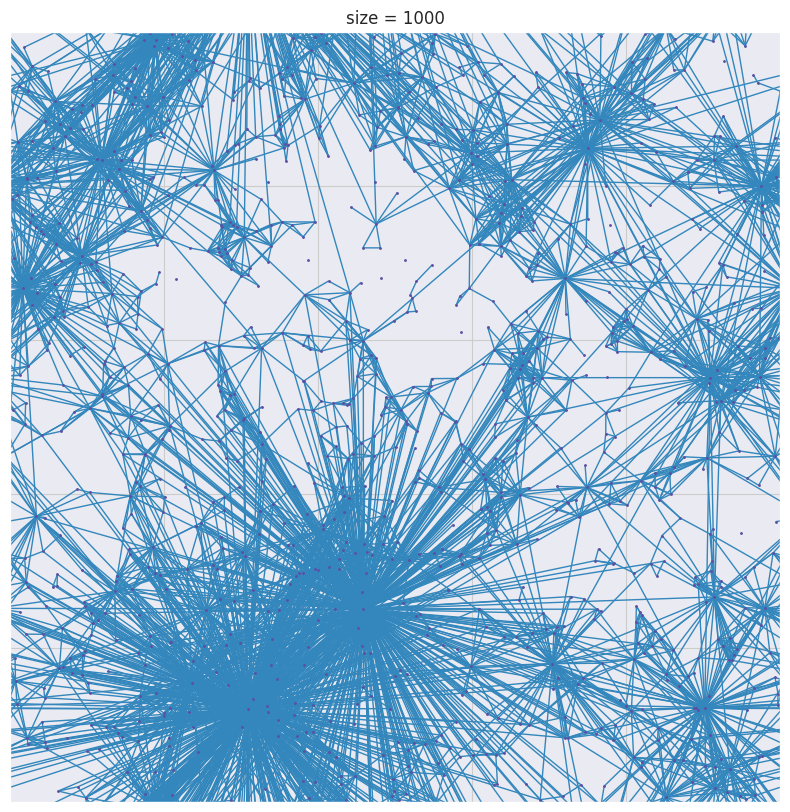

In [17]:
args = Args(
    graph_type="girg"
)

# generate graph
graph, dim = gen_graph(args)

# display settings
cmap = sns.color_palette("Spectral", as_cmap=True)

# set display graph
periodic = args.graph_type == "girg"
if periodic:
    p_graph = periodic_of(graph)
    display_graph = p_graph
else:
    display_graph = graph

# draw original graph (use to select good-looking graph)
fig_size = 10
fig, ax = plt.subplots(
    figsize=(fig_size, fig_size)
)

ax.set_title(f"size = {args.graph_size}", fontsize=12)
ax.set_aspect('equal')
ax.set_xlim(left=0, right=1)
ax.set_ylim(bottom=0, top=1)

nx.draw_networkx(
    display_graph,
    pos=display_graph.nodes.data("pos"),
    node_color=cmap(1.0),
    edge_color=cmap(0.9),
    with_labels=False,
    node_size=1.5,
    ax=ax
)

plt.savefig('./out/complete_out.pdf')

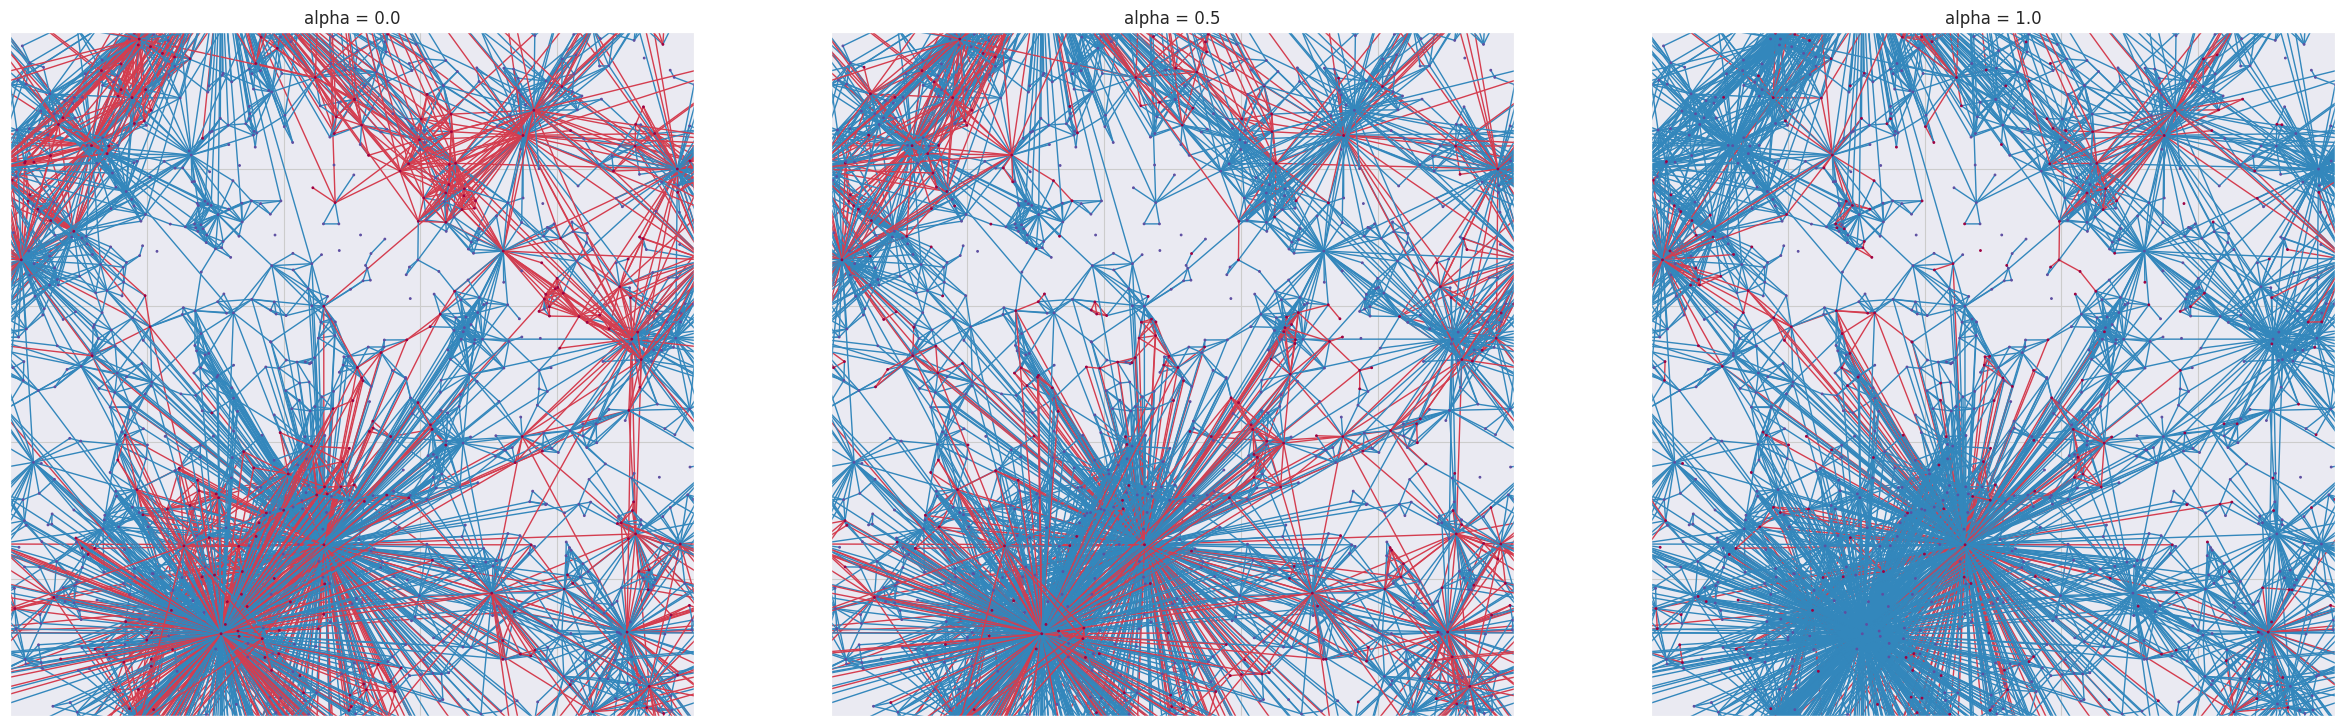

In [18]:
sub_args = [
    Args(
        # graph_size=graph_size,
        epoch_graph_size=250,
        epoch_graph_alpha=epoch_graph_alpha
    )
    # for graph_size in [500, 1000, 2500]
    #for epoch_graph_size in [50, 100, 250]
    for epoch_graph_alpha in [0.0, 0.5, 1.0]
]

fig_size = 10
fig, axs = plt.subplots(
    ncols=len(sub_args),
    nrows=1,
    figsize=(fig_size * len(sub_args), fig_size)
)

for i, a in enumerate(sub_args):

    ax = axs[i]

    ax.set_title(f"alpha = {a.epoch_graph_alpha}", fontsize=12)
    ax.set_aspect('equal')
    ax.set_xlim(left=0, right=1)
    ax.set_ylim(bottom=0, top=1)

    sub, _ = subgraph(
        graph=graph,
        size=a.epoch_graph_size,
        alpha=a.epoch_graph_alpha,
        boredom_pth=0.9,
    )

    node_colors = [
        cmap(0.0) if sub.has_node(non_periodic_node(node)) else cmap(1.0)
        for node in list(display_graph.nodes)
    ]

    edge_colors = [
        cmap(0.1) if sub.has_edge(non_periodic_node(u), non_periodic_node(v)) else cmap(0.9)
        for (u, v) in display_graph.edges
    ]

    nx.draw_networkx(
        display_graph,
        pos=display_graph.nodes.data("pos"),
        with_labels=False,
        node_size=1.5,
        node_color=node_colors,
        edge_color=edge_colors,
        ax=ax
    )

plt.savefig('./out/subs_out.pdf')

# Class imbalance

In [8]:
args_list = [
    Args(
        graph_type="girg",
        graph_size=graph_size,
    )
    for graph_size in [100, 250, 500, 750, 1000, 1500, 2000, 2500]
]

df_result = pd.DataFrame({})

for args in args_list:
    # generate graph
    graph, dim = gen_graph(args)
    ds = DatasetBuilder(graph, 100, "cpu")
    df_result = pd.concat([
        df_result,
        pd.Series({
            "n_nodes": ds.n_nodes,
            # graph data
            "amount": ds.n_edges,
            "type": "n_edges",
            # run args
            **asdict(args),
        }).to_frame().T,
        pd.Series({
            "n_nodes": ds.n_nodes,
            # graph data
            "amount": ds.n_non_edges,
            "type": "n_non_edges",
            # run args
            **asdict(args),
        }).to_frame().T
    ], ignore_index=True)

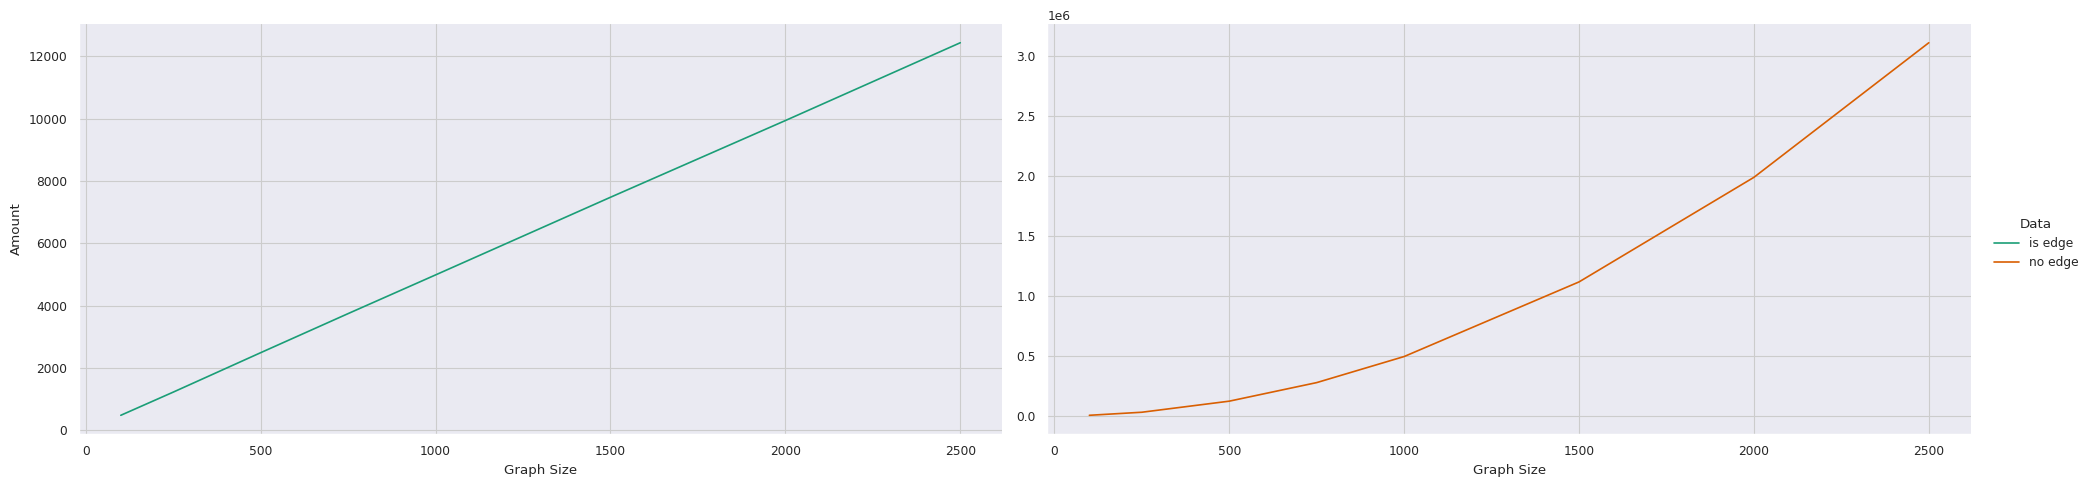

In [13]:
g = sns.relplot(
    data=df_result.assign(Data=df_result["type"].map({"n_non_edges": "no edge", "n_edges": "is edge"})), kind="line",
    col="Data",
    hue="Data",
    x="graph_size",
    y="amount",
    # errorbar="sd",
    palette=palette,
    aspect=2,
    facet_kws={
        'sharey': False,
        'sharex': True
    }
)
g.set_axis_labels("Graph Size", "Amount")
for item, ax in g.axes_dict.items():
    ax.set_title("")
g.fig.savefig('./out/dataset_composition_girg.pdf')

In [10]:
df_result.to_csv(f"./out/data_girg.csv.zip", index=False, compression=dict(method='zip', archive_name=f"data_girg.csv"))

In [75]:
df_result.assign(Data=df_result["type"].map({"n_non_edge": "no edge", "n_edge": "is edge"}))

n_nodes   amount         type batch_size epochs layers layer_size  \
0      100      487      n_edges         10    250     10         16   
1      100     4463  n_non_edges         10    250     10         16   
2      250     1260      n_edges         10    250     10         16   
3      250    29865  n_non_edges         10    250     10         16   
4      500     2432      n_edges         10    250     10         16   
5      500   122318  n_non_edges         10    250     10         16   
6      750     3792      n_edges         10    250     10         16   
7      750   277083  n_non_edges         10    250     10         16   
8     1000     5032      n_edges         10    250     10         16   
9     1000   494468  n_non_edges         10    250     10         16   
10    1500     7486      n_edges         10    250     10         16   
11    1500  1116764  n_non_edges         10    250     10         16   
12    2000    10022      n_edges         10    250     10         16   
13    2000  1988978  n_non_edges         10    250     10         16   
14    2500    12497      n_edges         10    250     10         16   
15    2500  3111253  n_non_edges         10    250     10         16   

   test_split valid_split eval_epochs  ... epoch_graph_boredom_pth  \
0         0.2         0.2        True  ...                     0.8   
1         0.2         0.2        True  ...                     0.8   
2         0.2         0.2        True  ...                     0.8   
3         0.2         0.2        True  ...                     0.8   
4         0.2         0.2        True  ...                     0.8   
5         0.2         0.2        True  ...                     0.8   
6         0.2         0.2        True  ...                     0.8   
7         0.2         0.2        True  ...                     0.8   
8         0.2         0.2        True  ...                     0.8   
9         0.2         0.2        True  ...                     0.8   
10        0.2         0.2        True  ...                     0.8   
11        0.2         0.2        True  ...                     0.8   
12        0.2         0.2        True  ...                     0.8   
13        0.2         0.2        True  ...                     0.8   
14        0.2         0.2        True  ...                     0.8   
15        0.2         0.2        True  ...                     0.8   

   random_seed graph_size graph_type rg_radius g_ple g_alpha g_deg note Data  
0         None        100       girg      0.05   2.5     inf    10    -  NaN  
1         None        100       girg      0.05   2.5     inf    10    -  NaN  
2         None        250       girg      0.05   2.5     inf    10    -  NaN  
3         None        250       girg      0.05   2.5     inf    10    -  NaN  
4         None        500       girg      0.05   2.5     inf    10    -  NaN  
5         None        500       girg      0.05   2.5     inf    10    -  NaN  
6         None        750       girg      0.05   2.5     inf    10    -  NaN  
7         None        750       girg      0.05   2.5     inf    10    -  NaN  
8         None       1000       girg      0.05   2.5     inf    10    -  NaN  
9         None       1000       girg      0.05   2.5     inf    10    -  NaN  
10        None       1500       girg      0.05   2.5     inf    10    -  NaN  
11        None       1500       girg      0.05   2.5     inf    10    -  NaN  
12        None       2000       girg      0.05   2.5     inf    10    -  NaN  
13        None       2000       girg      0.05   2.5     inf    10    -  NaN  
14        None       2500       girg      0.05   2.5     inf    10    -  NaN  
15        None       2500       girg      0.05   2.5     inf    10    -  NaN  

[16 rows x 23 columns]

In [78]:
df_result.assign(type=df_result["type"].map({"n_non_edges": "no edge", "n_edges": "is edge"}))["type"]

0     is edge
1     no edge
2     is edge
3     no edge
4     is edge
5     no edge
6     is edge
7     no edge
8     is edge
9     no edge
10    is edge
11    no edge
12    is edge
13    no edge
14    is edge
15    no edge
Name: type, dtype: object

# Subgraph Characteristics

In [34]:
sub_args = [
    Args(
        graph_size=graph_size,
        epoch_graph_size=epoch_graph_size,
        epoch_graph_alpha=epoch_graph_alpha
    )
    for graph_size in [500, 1000, 2500]
    for epoch_graph_size in [50, 100, 250]
    for epoch_graph_alpha in [0.0, 0.5, 1.0]
]
reps = 10
experiment_key = datetime.now().strftime("%d-%m--%H-%M")

def graph_char(_graph: nx.Graph) -> dict:
    return {
        "n_nodes": nx.number_of_nodes(_graph),
        "n_edges": nx.number_of_edges(_graph),
        "n_cliques": nx.number_of_cliques(_graph),
        "n_isolates": nx.number_of_isolates(_graph),
        "n_components": nx.number_connected_components(_graph),
        "connected": nx.is_connected(_graph),
        "transitivity": nx.transitivity(_graph),
        "average_clustering": nx.average_clustering(_graph),
        "average_degree": np.array([d for n, d in _graph.degree()]).sum() / nx.number_of_nodes(_graph),
    }

df_graphs = pd.DataFrame({})

for i, args in enumerate(sub_args):
    print(f"running {i}/{len(sub_args)}")

    graph, dim = gen_graph(args)
    df_graphs = pd.concat([
        df_graphs,
        pd.Series({
            # graph and subgraph chars
            "target": "graph",
            **graph_char(graph),
            # run args
            "args_i": i,
            **asdict(args),
        }).to_frame().T
    ], ignore_index=True)

    for rep in range(reps):
        sub, _ = subgraph(
            graph=graph,
            size=args.epoch_graph_size,
            alpha=args.epoch_graph_alpha,
            boredom_pth=0.8,
        )
        df_graphs = pd.concat([
            df_graphs,
            pd.Series({
                # graph and subgraph chars
                "target": "subgraph",
                **graph_char(sub),
                # run args
                "args_i": i,
                "rep": rep,
                **asdict(args),
            }).to_frame().T
        ], ignore_index=True)

        df_graphs.to_csv(f"./run-data/sub--{experiment_key}.csv.zip", index=False, compression=dict(method='zip', archive_name=f"sub--{experiment_key}.csv"))
print("done")

running 0/27
running 1/27
running 2/27
running 3/27
running 4/27
running 5/27
running 6/27
running 7/27
running 8/27
running 9/27
running 10/27
running 11/27
running 12/27
running 13/27
running 14/27
running 15/27
running 16/27
running 17/27
running 18/27
running 19/27
running 20/27
running 21/27
running 22/27
running 23/27
running 24/27
running 25/27
running 26/27
done


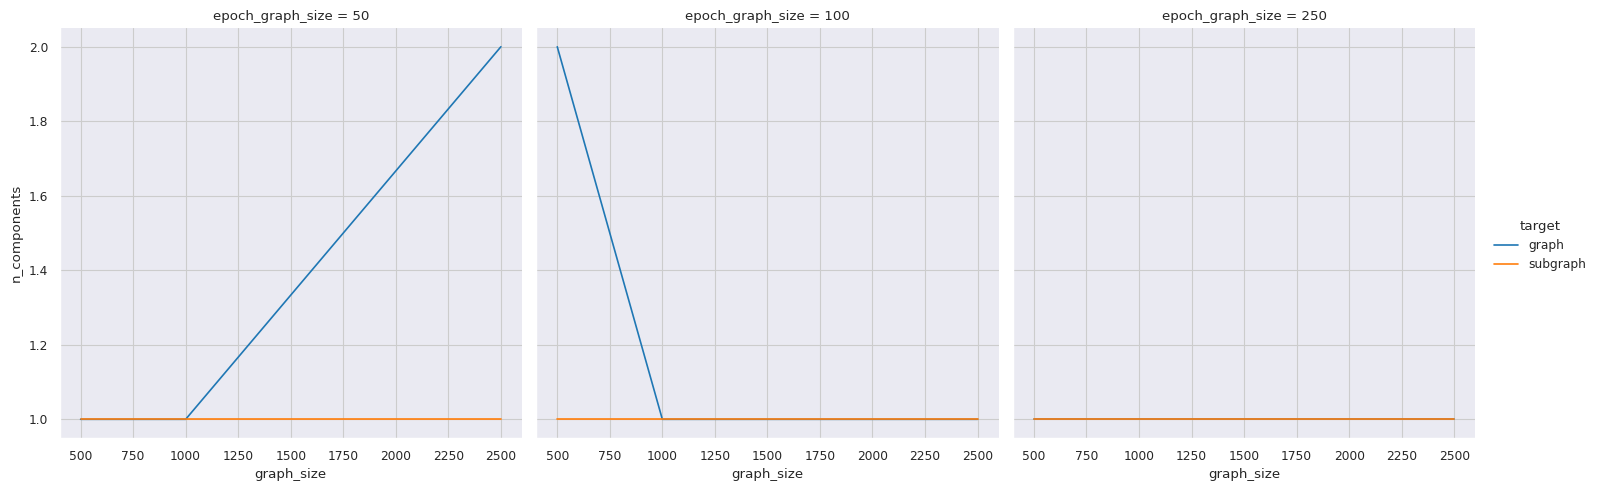

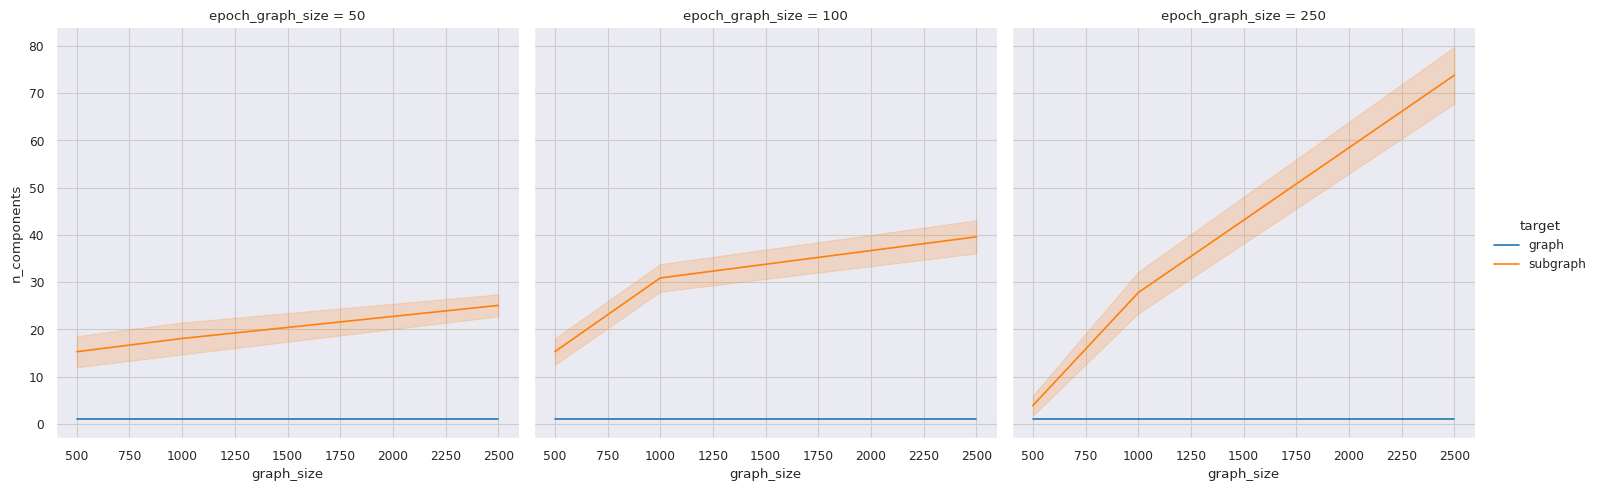

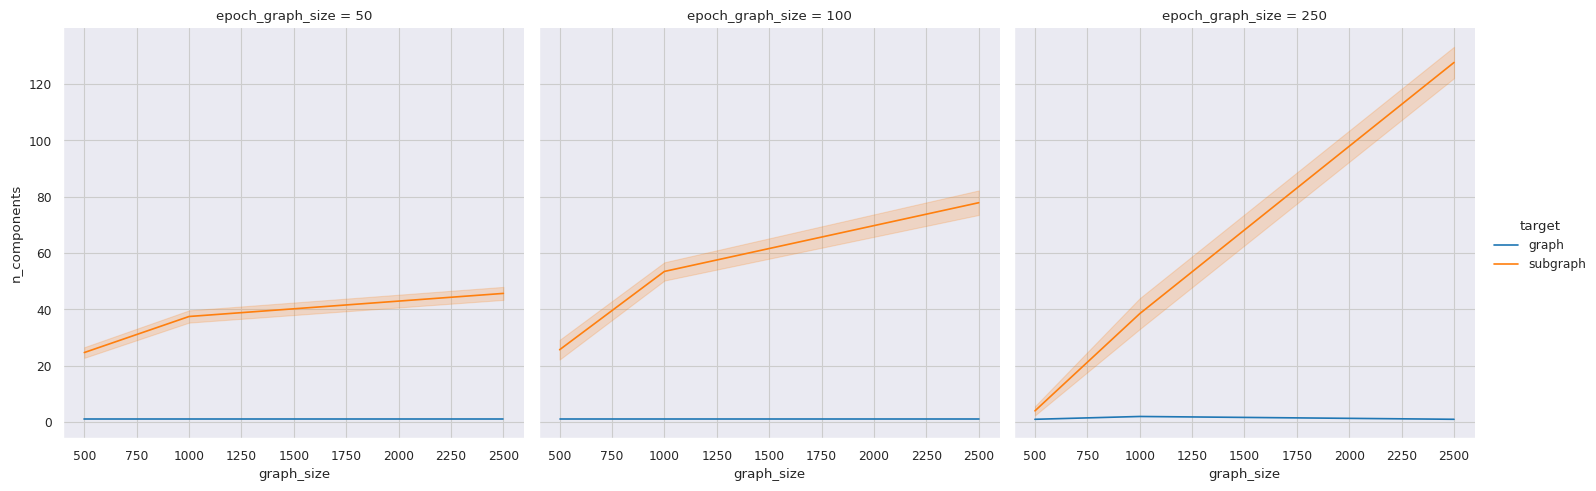

In [35]:
# plot grid search result
char_name = "n_components"

for i, a in enumerate([0.0, 0.5, 1.0]):
# for i, a in enumerate([0.0]):
    g = sns.relplot(
        data=df_graphs.loc[df_graphs["epoch_graph_alpha"] == a],
        x="graph_size",
        y=char_name,
        hue="target",
        col="epoch_graph_size",
        kind="line",
        errorbar="sd",
    )